# Cox Proportional Hazard Model
In this notebook, we will be performing Cox Regression using static variables to predict the risk of patients' survival. First, we load our training and test data and perform any necessary featuring to both predictive variables and targets. This will involve one-hot encoding any categorical variables, and calculating time to death/censuring.

In [262]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import os
from datetime import datetime
import math
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter, BreslowFlemingHarringtonFitter,CoxTimeVaryingFitter
from lifelines.utils import to_long_format, add_covariate_to_timeline, datetimes_to_durations
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sksurv.metrics import concordance_index_censored
from datetime import datetime, timedelta
import time
import json
import itertools
import pickle

In [250]:
# Access google drive data
data_dir = r"C:\Users\mgaut\Documents\Info_Vis_Project\Data"
train_path = os.path.join(data_dir, 'static_train_data.csv')
test_path = os.path.join(data_dir, 'static_test_data.csv')
val_path = os.path.join(data_dir, 'static_val_data.csv')


In [251]:
df = pd.read_csv(os.path.join(data_dir, 'static_patient_data_v2.csv'),
                 parse_dates = ['intime', 'outtime', 'DOD','DOD_HOSP','DOD_SSN'],
                 dtype={
                     'days_live':'Int64'
                     ,'years_live': 'Int64'
                     }
                 )
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'ICUSTAY_AGE_GROUP', 'intime',
       'DOD', 'hospital_deathtime', 'EXPIRE_FLAG', 'DOD_SSN', 'DOD_HOSP',
       'hospital_expire_flag', 'intime_1', 'outtime', 'ICUSTAY_EXPIRE_FLAG',
       'gender', 'icu_admit_age', 'admit_age', 'admittime'],
      dtype='object')

In [252]:
patient_df = df[df['ICUSTAY_AGE_GROUP'] == 'adult']
patient_df['survival_time'] = (patient_df['DOD'] - patient_df['intime'])/np.timedelta64(1,'D')
patient_df['length_stay'] = (patient_df['outtime'] - patient_df['intime'])/np.timedelta64(1,'D')
max_time = max(patient_df.survival_time.to_list())
patient_df['survival_time'] = patient_df['survival_time'].fillna(patient_df.survival_time.max())
patient_df['time'] = patient_df.apply(lambda row: math.floor(max(row.survival_time, row.length_stay)), axis=1)
patient_df['age_group'] = patient_df['admit_age'].map(lambda x: str(math.floor(x/10)*10) + 's')

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

## Cox Regression v.s. Kaplan Meier
To start, we will look at two different approaches for survival analysis - Kaplan Meier method and the Cox Proportional Hazard Model. First, the Kaplan Meier method is univariate, so this process will involve grouping patients by conditions (age group, illness, ethnicity, etc.) and generating a univariate regression for patients in each group by calculating the hazard at each time period (days). Second, the Cox Proportional Hazard Model is a multivariate model in which we calculate the relative hazard of each feature (or Covariate) and use these covariates to fit a exponential survival regression for each patient. 

### Kaplan Meier Model

In [253]:
kmf = KaplanMeierFitter()
kmf.fit(durations = patient_df['time'], event_observed = patient_df['EXPIRE_FLAG'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 50711 total observations, 28661 right-censored observations>

In [254]:
print("Median Survival Time: ", kmf.median_survival_time_)

Median Survival Time:  inf


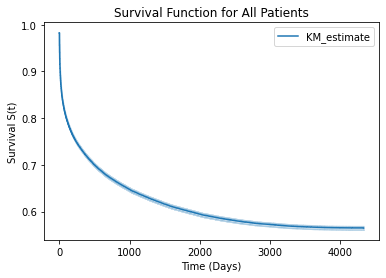

In [255]:
kmf.plot()
plt.title('Survival Function for All Patients')
plt.xlabel('Time (Days)')
plt.ylabel('Survival S(t)')
plt.show()

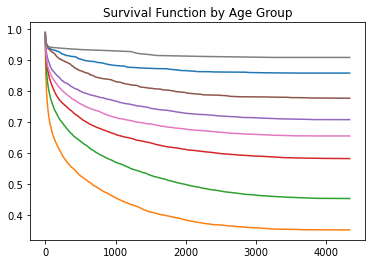

In [256]:
kmodel_df = patient_df[['time', 'EXPIRE_FLAG', 'age_group']]
age_groups = set(patient_df.age_group.to_list())

for age in age_groups:
    data = kmodel_df[kmodel_df.age_group==age]
    kmf = KaplanMeierFitter()
    kmf.fit(durations = data['time'], event_observed = data['EXPIRE_FLAG'])
    surv = kmf.survival_function_.reset_index()
    plt.plot(surv.timeline, surv.KM_estimate)
plt.title('Survival Function by Age Group')
plt.show()

In [257]:
model_df = patient_df[['time', 'EXPIRE_FLAG', 'admit_age', 'gender']]
input_df = pd.get_dummies(model_df, drop_first= True)
train_df, test_df = train_test_split(input_df, test_size = 0.3)

### Cox Proportional Hazard

In [258]:
cph = CoxPHFitter()
cph.fit(train_df, "time", event_col="EXPIRE_FLAG")

<lifelines.CoxPHFitter: fitted with 35497 total observations, 20013 right-censored observations>

In [259]:
test_curves = cph.predict_survival_function(test_df)
test_pred = cph.predict_expectation(test_df)
test_df['prediction'] = test_pred

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Survival S(t)')

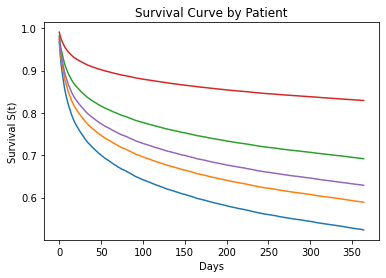

In [260]:
curve_example = test_curves.iloc[0:365, 0:5]
curve_example.plot()
plt.legend().remove()
plt.title('Survival Curve by Patient')
plt.legend().remove()
plt.xlabel('Days')
plt.ylabel('Survival S(t)')

In [261]:
math.sqrt(mean_squared_error(test_df.time, test_df.prediction))

1862.0845050870364

From this comparison we have chosen to go with a parametric method for predicting the survival curve for patients.

## Cox Regression
Now we will expand our Cox Regression to include both demographic and diagnosis data. We will need to one-hot encode categorical variables, and scale numeric variables to be in same number range as encoding (0 to 1).

In [28]:
def general_data_inputs(df, censor=None):
    df['time'] = pd.to_timedelta(df['time_until_death']) / np.timedelta64(1, 'D')
    #  Set censorship to max survival
    df.time = df.time.fillna(df.time.max()).apply(math.floor)
    #  Select variables that will be used for modeling
    df_input = pd.concat([df[['time', 'anytime_expire_flag', 'icu_admit_age','EMERGENCY']],
                         df.loc[:, 'female':'TSICU'],
                         df.loc[:, 'cardio' :'other']], axis = 1)
    # Scale Numerical variables to match range of one-hot variables
    scaler = MinMaxScaler()
    df_input.icu_admit_age = scaler.fit_transform(df_input.icu_admit_age.values.reshape(-1, 1))
    return df_input
    

In [29]:
train_data = pd.read_csv(train_path)
train_input = general_data_inputs(train_data)
test_input = general_data_inputs(pd.read_csv(test_path))
val_input = general_data_inputs(pd.read_csv(val_path))


In [30]:
cm = sns.light_palette('green', as_cmap=True)
train_input.corr().abs().style.background_gradient(cmap=cm, axis=0)

In [31]:
# Fit Cox regression to determine which variables have strong coefficient
coxph = CoxPHFitter()
coxph.fit(train_input, 'time', event_col='anytime_expire_flag')
cox_vars = coxph.summary.coef.abs()
strong_vars = cox_vars[cox_vars > 0.2].index.to_list()

# Fit new model with strong variables
n_train_input = train_input[['time', 'anytime_expire_flag'] + strong_vars]
n_coxph = CoxPHFitter()
n_coxph.fit(n_train_input, 'time', event_col='anytime_expire_flag')

<lifelines.CoxPHFitter: fitted with 23392 total observations, 14239 right-censored observations>

Text(0.5, 1.0, 'Strongest Variables - Diagnosis')

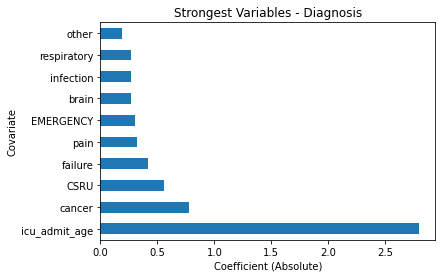

In [32]:
# TODO: Generate graph of the strongest variables for Cox Regression
cox_vars.sort_values(ascending= False)[:10].plot.barh()
plt.xlabel('Coefficient (Absolute)')
plt.ylabel('Covariate')
plt.title('Strongest Variables - Diagnosis')

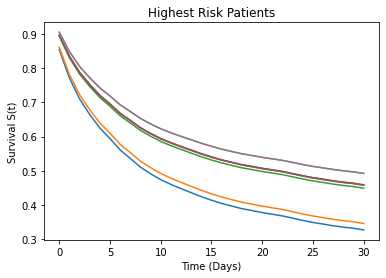

In [33]:
# test_curve
# Level 1: 100-90
# Level 2: 90-80
# Level 3: 80-70
# Level 4: 70-60
# Level 5: <60
test_curve = n_coxph.predict_survival_function(test_input[['time', 'anytime_expire_flag'] + strong_vars])
test_curve.T.sort_values(by=30).T.iloc[:31, :8].plot()
plt.ylabel('Survival S(t)')
plt.xlabel('Time (Days)')
plt.title('Highest Risk Patients')
plt.legend().remove()

In [54]:
test_curve

0         1         2         3         4         5         6     \
0.0     0.981942  0.968966  0.976457  0.985975  0.981298  0.960964  0.976549   
1.0     0.970461  0.949452  0.961558  0.977029  0.969414  0.936586  0.961708   
2.0     0.961331  0.934052  0.949749  0.969897  0.959967  0.917440  0.949943   
3.0     0.954008  0.921778  0.940301  0.964166  0.952393  0.902239  0.940530   
4.0     0.947288  0.910574  0.931652  0.958898  0.945443  0.888411  0.931913   
...          ...       ...       ...       ...       ...       ...       ...   
4110.0  0.599395  0.412529  0.512139  0.672533  0.588451  0.326818  0.513498   
4121.0  0.599346  0.412471  0.512085  0.672491  0.588402  0.326760  0.513444   
4140.0  0.599297  0.412413  0.512031  0.672448  0.588352  0.326703  0.513390   
4164.0  0.599249  0.412355  0.511977  0.672406  0.588303  0.326645  0.513335   
4292.0  0.599200  0.412298  0.511922  0.672364  0.588253  0.326587  0.513281   

            7         8         9     ...      7300      7301      7302  \
0.0     0.981847  0.992213  0.970075  ...  0.989198  0.995833  0.988328   
1.0     0.970307  0.987219  0.951241  ...  0.982289  0.993153  0.980868   
2.0     0.961131  0.983224  0.936368  ...  0.976771  0.991005  0.974913   
3.0     0.953771  0.980004  0.924507  ...  0.972330  0.989270  0.970122   
4.0     0.947017  0.977037  0.913676  ...  0.968242  0.987669  0.965714   
...          ...       ...       ...  ...       ...       ...       ...   
4110.0  0.597775  0.802859  0.426001  ...  0.737093  0.889338  0.719100   
4121.0  0.597726  0.802831  0.425943  ...  0.737057  0.889322  0.719062   
4140.0  0.597677  0.802803  0.425886  ...  0.737022  0.889305  0.719025   
4164.0  0.597629  0.802775  0.425828  ...  0.736986  0.889289  0.718987   
4292.0  0.597580  0.802747  0.425771  ...  0.736951  0.889272  0.718950   

            7303      7304      7305      7306      7307      7308      7309  
0.0     0.984729  0.989198  0.953758  0.993271  0.986463  0.987422  0.980569  
1.0     0.974998  0.982289  0.925059  0.988952  0.977824  0.979388  0.968231  
2.0     0.967246  0.976771  0.902618  0.985495  0.970936  0.972979  0.958426  
3.0     0.961021  0.972330  0.884864  0.982706  0.965399  0.967825  0.950568  
4.0     0.955301  0.968242  0.868762  0.980136  0.960309  0.963084  0.943360  
...          ...       ...       ...       ...       ...       ...       ...  
4110.0  0.649065  0.737093  0.264543  0.827256  0.681945  0.700806  0.576308  
4121.0  0.649021  0.737057  0.264488  0.827231  0.681903  0.700767  0.576258  
4140.0  0.648976  0.737022  0.264432  0.827206  0.681862  0.700727  0.576208  
4164.0  0.648932  0.736986  0.264376  0.827182  0.681821  0.700688  0.576157  
4292.0  0.648887  0.736951  0.264321  0.827157  0.681779  0.700648  0.576107  

[2268 rows x 7310 columns]

In [34]:
def classify_risk(score):
    
    if score >= 0.9:
        risk = 'Level 1'
    elif score >= 0.8:
        risk = 'Level 2'
    elif score >= 0.7:
        risk = 'Level 3'
    elif score >= 0.6:
        risk = 'Level 4'
    else:
        risk = 'Level 5'
    
    return risk
    

In [35]:
risk_levels = test_curve.applymap(classify_risk)
levels_risk = risk_levels.T[30]
test_levels = pd.concat([test_input, levels_risk], axis=1)

Text(0, 0.5, 'Patients')

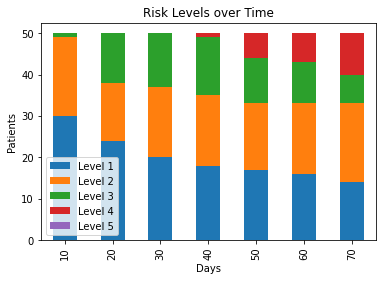

In [36]:
risk_counts = risk_levels.iloc[:365,:50].apply(Counter, axis = 1)
count_risks = pd.DataFrame.from_dict(risk_counts.to_list(), orient='columns')
count_risks[count_risks.index.isin([10, 20, 30, 40, 50, 60, 70])].plot.bar(stacked = True)
plt.title('Risk Levels over Time')
plt.xlabel('Days')
plt.ylabel('Patients')

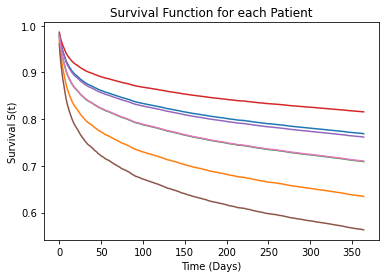

In [37]:
test_curve.iloc[0:365, 0:7].plot()
plt.title('Survival Function for each Patient')
plt.xlabel('Time (Days)')
plt.ylabel('Survival S(t)')
plt.legend().remove()

In [38]:
# math.sqrt(mean_squared_error(test_data.time, test_data.prediction))
n_coxph.score(test_input[['time', 'anytime_expire_flag'] + strong_vars], scoring_method= 'concordance_index')

# Run against test set

0.6853180762116574

In [39]:
strong_val = val_input[['time', 'anytime_expire_flag'] + strong_vars]
n_coxph.score(strong_val, scoring_method='concordance_index')

0.696853627892147

# Accelerated Failure Time Model (AFT)
Next we will work with the AFT model to try to handle non-constant hazards, and improve time to event prediction.

In [ ]:
aft_input = train_input[train_input.time > 0]
# train_input.time = train_input.time.apply(lambda x: 0.1 if x==0 else x)

aft = WeibullAFTFitter()
aft.fit(aft_input, 'time', event_col='anytime_expire_flag')

In [ ]:
test_pred_aft = aft.predict_survival_function(test_input[test_input.time > 0])
test_pred_aft.iloc[0:365, 0:7].plot()
plt.title('Accelerated Failure Time')
plt.xlabel('')

In [ ]:
aft.score(val_input[val_input.time > 0], scoring_method='concordance_index')
# aft.predict_expectation(test_input)

# Boosting for Prediction
We will need to incorporate ensemble modeling if we are going to optimize time to event prediction. For this we are going to use the XGBoost library with both Cox Proportional Hazards and Accelerated Failure Time.

## Cox Regression

### XGBoost
First we will need to reformat our data to meet the input and target requirements for XGBoost

In [ ]:
x_train = train_input

# Make dates of censoring
censor_date = x_train.time.max()
x_target = x_train.time.apply(lambda x: -x if x == censor_date else x)

# Reformat data to work with XGBoost format
x_input = x_train.drop(['time', 'anytime_expire_flag'], axis=1)
D_train = xgb.DMatrix(x_input, label = x_target)

param ={
    'eta' : 0.01,
    'booster' : 'gbtree',
    'objective' : 'survival:cox',
    'eval-metric' : 'cox-nloglik',
    'max_depth':10,
    'gamma':0
}

rounds = 50

cox = xgb.train(param, D_train, rounds)

In [ ]:
# Reformat Test data
x_test = test_input

# Make dates of censoring
test_censor = x_test.time.max()
x_test_target = x_test.time.apply(lambda x: -x if x == test_censor else x)

# Reformat data to work with XGBoost format
x_test_input = x_test.drop(['time', 'anytime_expire_flag'], axis=1)
D_test = xgb.DMatrix(x_test_input, label=x_test_target)

# Reformat Val data
x_val = val_input
val_censor = x_val.time.max()
x_val_input = x_val.drop(['time', 'anytime_expire_flag'], axis=1)
x_val_target = x_val.time.apply(lambda x: -x if x == val_censor else x)
D_val = xgb.DMatrix(x_val_input, label=x_val_target)

In [ ]:
pred = cox.predict(D_val)
event = val_input.anytime_expire_flag.apply(lambda x: False if x==0 else True)
concordance_index_censored(event, val_input.time, pred)[0]

### Scikit-Survival
Now we will try with scikit-survival

In [ ]:
s_input = train_input.loc[:, 'icu_admit_age':]
s_target = train_input[['anytime_expire_flag', 'time']]
s_target.anytime_expire_flag = s_target.anytime_expire_flag.apply(lambda x: False if x==0 else True)
s_target = s_target.to_records(index=False)

s_test = test_input.loc[:, 'icu_admit_age':]
s_test_target = test_input[['anytime_expire_flag', 'time']]
s_test_target.anytime_expire_flag = s_test_target.anytime_expire_flag.apply(lambda x: False if x==0 else True)
s_test_target = s_test_target.to_records(index=False)

s_val = val_input.loc[:, 'icu_admit_age':]
s_val_target = val_input[['anytime_expire_flag', 'time']]
s_val_target.anytime_expire_flag = s_val_target.anytime_expire_flag.apply(lambda x: False if x==0 else True)
s_val_target = s_val_target.to_records(index=False)

coxph = CoxPHSurvivalAnalysis()
estimator = coxph.fit(s_input, s_target)

In [ ]:
def scikit_input_targets(df):
    inputs = df.drop(labels=['anytime_expire_flag', 'time'], axis=1)
    targets = df[['anytime_expire_flag', 'time']]
    targets.anytime_expire_flag = targets.anytime_expire_flag.apply(lambda x: False if x==0 else True)
    s_targets = targets.to_records(index=False)
    return inputs, s_targets

In [ ]:
s_train, s_train_target = scikit_input_targets(train_input)
s_test, s_test_target = scikit_input_targets(test_input)
s_val, s_val_target = scikit_input_targets(val_input)

coxph = CoxPHSurvivalAnalysis()
estimator = coxph.fit(s_train, s_train_target)

In [ ]:
estimator.score(s_val, s_val_target)

In [ ]:
n_estimator = CoxPHSurvivalAnalysis().fit(s_train[strong_vars], s_train_target)

In [ ]:
n_estimator.score(s_val[strong_vars], s_val_target)

## Grid Search

Now we will try Boosting and Random Forest using the scikit-survival library

In [ ]:
config_path = "C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\grid_config.json"
with open(config_path, "r") as config_file:
    config = json.load(config_file)
model_type = config['type']
param_path = config['param_path']
with open(param_path, "r") as param_file:
    param_dict = json.load(param_file)
param_dict

In [ ]:
def model_concordance_index(y, y_pred):
    df = pd.DataFrame(y)
    event = df.iloc[:,0]
    time = df.iloc[:,1]
    return concordance_index_censored(event, time, y_pred)[0]
   

In [ ]:
boost_param_grid = {
    'max_depth' : [1, 2, 3, 4, 5],
    'n_estimators' : [50, 100, 250, 500],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3]   
}

In [ ]:
g_boost = GradientBoostingSurvivalAnalysis()
cv=3

In [ ]:
boost_grid = GridSearchCV(
            estimator=g_boost,
            param_grid=boost_param_grid,
            cv=cv,
            n_jobs=-1,
            scoring=make_scorer(model_concordance_index, greater_is_better=True),
            verbose=2
        )
boost_grid.fit(s_train, s_train_target)

In [ ]:
boost_grid.best_score_

In [ ]:
gboost_params = grid.best_params_

In [ ]:
new_boost = GradientBoostingSurvivalAnalysis(**gboost_params)
new_boost.fit(s_input, s_target)
new_boost.score(s_val, s_val_target)

In [ ]:
rf_params = {
    'max_depth' : [2, 3, 4, 5, 6],
    'n_estimators' : [100, 250, 500, 1000]
}
rf_model = RandomSurvivalForest()
cv = 3

In [ ]:
rf_grid = GridSearchCV(
            estimator=rf_model,
            param_grid=rf_params,
            cv=cv,
            n_jobs=-1,
            scoring=make_scorer(model_concordance_index, greater_is_better=True),
            verbose=2
        )
rf_grid.fit(s_input, s_target)

In [ ]:
rf_grid.best_score_

In [ ]:
best_rf_params = rf_grid.best_params_
n_rf = RandomSurvivalForest(**new_rf_params)
new_rf.fit(s_input, s_target)
new_rf.score(s_val, s_val_target)

In [ ]:
grid1.cv_results_['rank_test_score']

## Grid Search with ICD codes

In [263]:
# import pandas_ml as pdml
icd_train = pd.read_csv("C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\icd_static_train_data.csv",
                       parse_dates = ['admittime', 'dischtime', 'intime', 'outtime'])
icd_test = pd.read_csv("C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\icd_static_test_data.csv",
                       parse_dates = ['admittime', 'dischtime', 'intime', 'outtime'])
icd_val = pd.read_csv("C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\icd_static_val_data.csv",
                       parse_dates = ['admittime', 'dischtime', 'intime', 'outtime'])

In [264]:
def make_icu_targets(df):
    s_input = df.drop(labels=['time', 'icu_expire_flag'], axis=1)
    s_target = df[['icu_expire_flag', 'time']]
    s_target.icu_expire_flag = s_target.icu_expire_flag.apply(lambda x: False if x==0 else True)
    s_target = s_target.to_records(index=False)
    return s_input, s_target

In [265]:
def resampling_df(df, zero_class=0.6, one_class=0.4):
    sample_ratio = zero_class / one_class
    df_0 = df[df.icu_expire_flag==0]
    df_1 = df[df.icu_expire_flag==1]
    rows, cols = df_1.shape
    df_0 = df_0.sample(int(sample_ratio*rows))
    return pd.concat([df_1,df_0], axis=0)
    

In [266]:
icd_train_vars = icd_train.loc[:,'icu_admit_age':'icd_skin'].drop(labels=['dbsource','marital_status','insurance'], axis=1)
icd_train_vars = pd.get_dummies(icd_train_vars)
icd_test_vars = icd_test.loc[:,'icu_admit_age':'icd_skin'].drop(labels=['dbsource','marital_status','insurance'], axis=1)
icd_test_vars = pd.get_dummies(icd_test_vars)

icd_icu_train = icd_train[['icu_expire_flag', 'hours_until_death', 'hours_until_leave_ICU']]
icd_icu_test = icd_test[['icu_expire_flag', 'hours_until_death', 'hours_until_leave_ICU']]
icd_icu_val = icd_val[['icu_expire_flag', 'hours_until_death', 'hours_until_leave_ICU']]

icu_train_df = pd.concat([icd_icu_train, icd_train_vars],axis=1)
icu_test_df = pd.concat([icd_icu_test, icd_test_vars], axis=1)
icu_train_df['time'] = icu_train_df.apply(lambda row: min(row.hours_until_leave_ICU, row.hours_until_death), axis=1)
icu_test_df['time'] = icu_test_df.apply(lambda row: min(row.hours_until_leave_ICU, row.hours_until_death), axis=1)
# icu_train_df = resampling_df(icu_train_df)

icu_test_df
icu_train, icu_train_target = make_icu_targets(icu_train_df)
icu_test, icu_test_target = make_icu_targets(icu_test_df)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [267]:
icu_train_df

icu_expire_flag  hours_until_death  hours_until_leave_ICU  \
0                    0              489.0                   54.0   
1                    0           103018.0                   27.0   
2                    0           103018.0                  119.0   
3                    0           103018.0                   24.0   
4                    0           103018.0                   52.0   
...                ...                ...                    ...   
23387                1              159.0                  160.0   
23388                1              299.0                  307.0   
23389                0           103018.0                   25.0   
23390                0           103018.0                  311.0   
23391                0             2496.0                  233.0   

       icu_admit_age  female  icd_blood  icd_circulatory  icd_congenital  \
0                 64       0        2.0              3.0             0.0   
1                 70       0        1.0              5.0             0.0   
2                 81       1        2.0              2.0             0.0   
3                 76       0        2.0              8.0             0.0   
4                 51       0        0.0              0.0             0.0   
...              ...     ...        ...              ...             ...   
23387             77       1        1.0              0.0             0.0   
23388             82       1        2.0              6.0             0.0   
23389             35       0        1.0              0.0             0.0   
23390             61       0        0.0              2.0             0.0   
23391             85       0        0.0              1.0             0.0   

       icd_digestive  icd_endocrine  ...  icd_skin  first_careunit_CCU  \
0                4.0            3.0  ...       0.0                   0   
1                0.0            0.0  ...       0.0                   0   
2                8.0            4.0  ...       1.0                   0   
3                1.0            2.0  ...       0.0                   0   
4                1.0            0.0  ...       1.0                   0   
...              ...            ...  ...       ...                 ...   
23387            0.0            0.0  ...       0.0                   0   
23388            0.0            3.0  ...       0.0                   0   
23389            1.0            0.0  ...       0.0                   0   
23390            0.0            1.0  ...       0.0                   1   
23391            3.0            0.0  ...       0.0                   0   

       first_careunit_CSRU  first_careunit_MICU  first_careunit_SICU  \
0                        0                    1                    0   
1                        1                    0                    0   
2                        0                    1                    0   
3                        0                    1                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
23387                    0                    0                    0   
23388                    0                    1                    0   
23389                    0                    1                    0   
23390                    0                    0                    0   
23391                    0                    1                    0   

       first_careunit_TSICU  admission_type_ELECTIVE  \
0                         0                        0   
1                         0                        1   
2                         0                        0   
3                         0                        0   
4                         1                        1   
...                     ...                      ...   
23387                     1                        0   
23388                     0                        0   
23389              

In [268]:
icu_rf_params = {
    'max_depth' : 8,
    'n_estimators' : 500,
    'n_jobs' : -1
}

icu_rf = RandomSurvivalForest(**icu_rf_params)
icu_rf.fit(icu_train, icu_train_target)

RandomSurvivalForest(max_depth=8, n_estimators=500, n_jobs=-1)

In [269]:
icu_rf.score(icu_test, icu_test_target)

0.9759444424689075

In [207]:
icu_cumhaz_curves = pd.DataFrame(icu_rf.predict_cumulative_hazard_function(icu_test))
icu_cumhaz_curves = icd_test[['subject_id']].reset_index().join(icu_cumhaz_curves).drop(labels = ['index'], axis=1)
icu_cumhaz_curves_path = 'C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\icu_cumhaz_curves.csv'
icu_cumhaz_curves.to_csv(icu_cumhaz_curves_path)
# icu_cumhaz_curves.columns = [str(i) for i in icu_cumhaz_curves.columns.to_list()]
# icu_cumhaz_curves.to_feather(icu_cumhaz_curves_path)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\sksurv\ensemble\forest.py:462: FutureWarning: predict_cumulative_hazard_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  FutureWarning)


In [271]:
icu_surv_curves = pd.DataFrame(icu_rf.predict_survival_function(icu_test))
icu_surv_curves = icd_test[['subject_id']].reset_index().join(icu_surv_curves).drop(labels = ['index'], axis=1)
icu_surv_curves_path = 'C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\unbalanced_icu_surv_curves.csv'
icu_surv_curves.to_csv(icu_surv_curves_path)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\sksurv\ensemble\forest.py:530: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  FutureWarning)


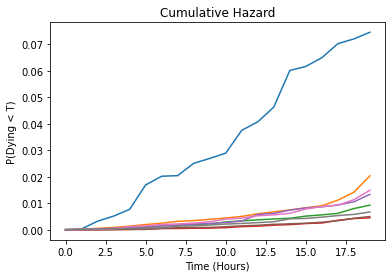

In [205]:
icu_cumhaz_curves.sample(8).drop(labels=['subject_id'],axis=1).T.iloc[:20,:].plot()
plt.title('Cumulative Hazard')
plt.xlabel('Time (Hours)')
plt.ylabel('P(Dying < T)')
plt.legend().remove()

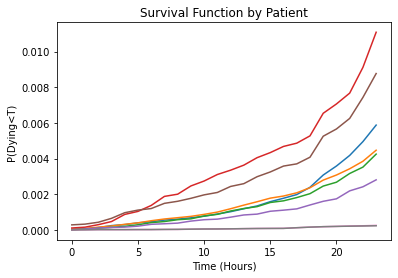

In [300]:
icu_surv_plot = icu_surv_curves.sample(8).drop(labels=['subject_id'],axis=1).T.iloc[:24,:]
icu_surv_plot = icu_surv_plot.apply(lambda x: 1-x)
icu_surv_plot.plot()
plt.title('Survival Function by Patient')
plt.xlabel('Time (Hours)')
plt.ylabel('P(Dying<T)')
plt.legend().remove()

In [75]:
icd_icu_train['time'] = icd_icu_train.apply(lambda row: min(row.hours_until_leave_ICU, row.hours_until_death), axis=1)
icd_icu_test['time'] = icd_icu_test.apply(lambda row: min(row.hours_until_leave_ICU, row.hours_until_death), axis=1)
icd_icu_val['time'] = icd_icu_val.apply(lambda row: min(row.hours_until_leave_ICU, row.hours_until_death), axis=1)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [76]:
icd_icu_train

icu_expire_flag  hours_until_death  hours_until_leave_ICU   time
0                    0              489.0                   54.0   54.0
1                    0           103018.0                   27.0   27.0
2                    0           103018.0                  119.0  119.0
3                    0           103018.0                   24.0   24.0
4                    0           103018.0                   52.0   52.0
...                ...                ...                    ...    ...
23387                1              159.0                  160.0  159.0
23388                1              299.0                  307.0  299.0
23389                0           103018.0                   25.0   25.0
23390                0           103018.0                  311.0  311.0
23391                0             2496.0                  233.0  233.0

[23392 rows x 4 columns]

In [77]:
icu_train_input, icu_test_input, icu_val_input = generate_icd_data(icd_train, icd_test, icd_val)

In [78]:
icu_train_input

subject_id  anytime_expire_flag  icu_admit_age  hours_until_leave_ICU  \
0           87995                    1       0.662162               0.014618   
1           28546                    0       0.743243               0.007309   
2           86648                    0       0.891892               0.032214   
3           52087                    0       0.824324               0.006497   
4           77625                    0       0.486486               0.014077   
...           ...                  ...            ...                    ...   
23387       10784                    1       0.837838               0.043313   
23388       80518                    1       0.905405               0.083108   
23389       26059                    0       0.270270               0.006768   
23390       23626                    0       0.621622               0.084191   
23391        4877                    1       0.945946               0.063075   

       female  first_careunit_CCU  first_careunit_CSRU  first_careunit_MICU  \
0           0                   0                    0                    1   
1           0                   0                    1                    0   
2           1                   0                    0                    1   
3           0                   0                    0                    1   
4           0                   0                    0                    0   
...       ...                 ...                  ...                  ...   
23387       1                   0                    0                    0   
23388       1                   0                    0                    1   
23389       0                   0                    0                    1   
23390       0                   1                    0                    0   
23391       0                   0                    0                    1   

       first_careunit_SICU  first_careunit_TSICU  ...  icd_mental  icd_misc  \
0                        0                     0  ...         1.0       0.0   
1                        0                     0  ...         0.0       0.0   
2                        0                     0  ...         0.0       3.0   
3                        0                     0  ...         1.0       2.0   
4                        0                     1  ...         0.0       0.0   
...                    ...                   ...  ...         ...       ...   
23387                    0                     1  ...         0.0       0.0   
23388                    0                     0  ...         0.0       2.0   
23389                    0                     0  ...         3.0       0.0   
23390                    0                     0  ...         0.0       0.0   
23391                    0                     0  ...         0.0       1.0   

       icd_muscular  icd_neoplasms  icd_nervous  icd_pregnancy  icd_prenatal  \
0               0.0            0.0          0.0            0.0           0.0   
1               0.0            0.0          0.0            0.0           0.0   
2               1.0            0.0          1.0            0.0           1.0   
3               0.0            0.0          0.0            0.0           0.0   
4               0.0            0.0          1.0            0.0           0.0   
...             ...            ...          ...            ...           ...   
23387           1.0            0.0          0.0            0.0           0.0   
23388           0.0            0.0          0.0            0.0           0.0   
23389           0.0            0.0          0.0            0.0           0.0   
23390           0.0            0.0          0.0            0.0           1.0   
23391           0.0            0.0          0.0            0.0           0.0   

       icd_respiratory  icd_skin    time  
0                  0.0       0.0    20.0  
1                  1.0       0.0  4332.0  
2                  6.0       1.0  4332.0  
3              

In [79]:
icd_icu_train = pd.concat([icd_train_input.drop(labels=['anytime_expire_flag', 'hours_until_leave_ICU', 'time', 'subject_id'], axis=1),
          icd_icu_train[['icu_expire_flag', 'time']]], axis=1)
icd_icu_test = pd.concat([icd_test_input.drop(labels=['anytime_expire_flag', 'hours_until_leave_ICU', 'time', 'subject_id'], axis=1),
          icd_icu_test[['icu_expire_flag', 'time']]], axis=1)
icd_icu_val = pd.concat([icd_val_input.drop(labels=['anytime_expire_flag', 'hours_until_leave_ICU', 'time', 'subject_id'], axis=1),
          icd_icu_val[['icu_expire_flag', 'time']]], axis=1)

In [80]:
icd_icu_test

icu_admit_age  female  first_careunit_CCU  first_careunit_CSRU  \
0          0.905405     0.0                 0.0                  1.0   
1          0.783784     0.0                 0.0                  0.0   
2          0.864865     1.0                 1.0                  0.0   
3          0.918919     0.0                 0.0                  1.0   
4          0.797297     0.0                 0.0                  0.0   
...             ...     ...                 ...                  ...   
7305       0.932432     0.0                 1.0                  0.0   
7306            NaN     NaN                 NaN                  NaN   
7307       0.554054     0.0                 0.0                  0.0   
7308       0.527027     0.0                 1.0                  0.0   
7309       0.932432     0.0                 0.0                  1.0   

      first_careunit_MICU  first_careunit_SICU  first_careunit_TSICU  \
0                     0.0                  0.0                   0.0   
1                     0.0                  1.0                   0.0   
2                     0.0                  0.0                   0.0   
3                     0.0                  0.0                   0.0   
4                     1.0                  0.0                   0.0   
...                   ...                  ...                   ...   
7305                  0.0                  0.0                   0.0   
7306                  NaN                  NaN                   NaN   
7307                  1.0                  0.0                   0.0   
7308                  0.0                  0.0                   0.0   
7309                  0.0                  0.0                   0.0   

      admission_type_ELECTIVE  admission_type_URGENT  icd_blood  ...  \
0                         0.0                    0.0        0.0  ...   
1                         0.0                    0.0        0.0  ...   
2                         0.0                    1.0        0.0  ...   
3                         1.0                    0.0        1.0  ...   
4                         0.0                    0.0        2.0  ...   
...                       ...                    ...        ...  ...   
7305                      0.0                    0.0        0.0  ...   
7306                      NaN                    NaN        NaN  ...   
7307                      0.0                    0.0        0.0  ...   
7308                      0.0                    0.0        1.0  ...   
7309                      0.0                    0.0        0.0  ...   

      icd_misc  icd_muscular  icd_neoplasms  icd_nervous  icd_pregnancy  \
0          0.0           0.0            0.0          0.0            0.0   
1          0.0           0.0            0.0          0.0            0.0   
2          0.0           0.0            0.0          0.0            0.0   
3          0.0           0.0            0.0          1.0            0.0   
4          2.0           0.0            2.0          0.0            0.0   
...        ...           ...            ...          ...            ...   
7305       0.0           1.0            0.0          0.0            0.0   
7306       NaN           NaN            NaN          NaN            NaN   
7307       0.0           0.0            0.0          0.0            0.0   
7308       0.0           0.0            0.0          0.0            0.0   
7309       1.0           0.0            0.0          0.0            0.0   

      icd_prenatal  icd_respiratory  icd_skin  icu_expire_flag   time  
0              0.0              0.0       0.0                0   53.0  
1              0.0              2.0       0.0                0  549.0  
2              0.0              2.0       0.0                0   42.0  
3              0.0              0.0       0.0                0   27.0  
4              0.0              2.0       2.0                0  423.0  
...            ...              ...       ...              ...    ...  
7305  

In [60]:
icu_train_df, icu_train_targets = make_icu_targets(icd_icu_train)
icu_test_df, icu_test_targets = make_icu_targets(icd_icu_test)
icu_val_df, icu_val_targets = make_icu_targets(icd_icu_val)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [89]:
icd_icu_train[icd_icu_train.icu_expire_flag==0]

icu_admit_age  female  first_careunit_CCU  first_careunit_CSRU  \
0           0.662162     0.0                 0.0                  0.0   
1           0.743243     0.0                 0.0                  1.0   
2           0.891892     1.0                 0.0                  0.0   
3           0.824324     0.0                 0.0                  0.0   
4           0.486486     0.0                 0.0                  0.0   
...              ...     ...                 ...                  ...   
23385       0.743243     1.0                 0.0                  0.0   
23386       0.459459     1.0                 0.0                  1.0   
23389       0.270270     0.0                 0.0                  0.0   
23390       0.621622     0.0                 1.0                  0.0   
23391       0.945946     0.0                 0.0                  0.0   

       first_careunit_MICU  first_careunit_SICU  first_careunit_TSICU  \
0                      1.0                  0.0                   0.0   
1                      0.0                  0.0                   0.0   
2                      1.0                  0.0                   0.0   
3                      1.0                  0.0                   0.0   
4                      0.0                  0.0                   1.0   
...                    ...                  ...                   ...   
23385                  1.0                  0.0                   0.0   
23386                  0.0                  0.0                   0.0   
23389                  1.0                  0.0                   0.0   
23390                  0.0                  0.0                   0.0   
23391                  1.0                  0.0                   0.0   

       admission_type_ELECTIVE  admission_type_URGENT  icd_blood  ...  \
0                          0.0                    0.0        2.0  ...   
1                          1.0                    0.0        1.0  ...   
2                          0.0                    0.0        2.0  ...   
3                          0.0                    0.0        2.0  ...   
4                          1.0                    0.0        0.0  ...   
...                        ...                    ...        ...  ...   
23385                      0.0                    0.0        0.0  ...   
23386                      1.0                    0.0        0.0  ...   
23389                      0.0                    0.0        1.0  ...   
23390                      0.0                    0.0        0.0  ...   
23391                      0.0                    0.0        0.0  ...   

       icd_misc  icd_muscular  icd_neoplasms  icd_nervous  icd_pregnancy  \
0           0.0           0.0            0.0          0.0            0.0   
1           0.0           0.0            0.0          0.0            0.0   
2           3.0           1.0            0.0          1.0            0.0   
3           2.0           0.0            0.0          0.0            0.0   
4           0.0           0.0            0.0          1.0            0.0   
...         ...           ...            ...          ...            ...   
23385       0.0           0.0            0.0          0.0            0.0   
23386       0.0           0.0            0.0          0.0            0.0   
23389       0.0           0.0            0.0          0.0            0.0   
23390       0.0           0.0            0.0          0.0            0.0   
23391       1.0           0.0            0.0          0.0            0.0   

       icd_prenatal  icd_respiratory  icd_skin  icu_expire_flag   time  
0               0.0              0.0       0.0                0   54.0  
1               0.0              1.0       0.0                0   27.0  
2               1.0              6.0       1.0                0  119.0  
3               0.0              0.0       0.0                0   24.0  
4               0.0              2.0       1.0                0   52.0  
...             ...      

In [226]:
s_icd_train = icd_train[(icd_train.hospital_expire_flag == 0) & (icd_train.icu_expire_flag == 0)]
s_icd_test = icd_test[(icd_test.hospital_expire_flag == 0) & (icd_test.icu_expire_flag == 0)]
s_icd_val = icd_val[(icd_val.hospital_expire_flag == 0) & (icd_val.icu_expire_flag == 0)]


In [227]:
def generate_icd_data(train, test, valid):
    time_age = pd.concat([train[['days_until_death', 'icu_admit_age', 'hours_until_leave_ICU']],
                          test[['days_until_death', 'icu_admit_age', 'hours_until_leave_ICU']],
                          valid[['days_until_death', 'icu_admit_age', 'hours_until_leave_ICU']]], axis = 0)
    censor = time_age.days_until_death.max()
    scaler = MinMaxScaler()
    scaler.fit(time_age.icu_admit_age.values.reshape(-1, 1))
    
    h_scaler = MinMaxScaler()
    h_scaler.fit(time_age.hours_until_leave_ICU.values.reshape(-1, 1))
    
    train_df = transform_icd_df(train, scaler, h_scaler, censor)
    test_df = transform_icd_df(test, scaler, h_scaler, censor)
    valid_df = transform_icd_df(valid, scaler, h_scaler, censor)
    
    return train_df, test_df, valid_df
    
    


def transform_icd_df(df, t_scaler, h_scaler, censor):
    icd_df = pd.concat([df[['subject_id', 'anytime_expire_flag', 'days_until_death',
                            'icu_admit_age', 'hours_until_leave_ICU', 'female']],
                        pd.get_dummies(df[['first_careunit', 'admission_type']]),
                        df.loc[:,'icd_blood':'icd_skin']], axis=1)
    icd_df['time'] = icd_df.days_until_death.fillna(censor)
    icd_df.icu_admit_age = t_scaler.transform(icd_df.icu_admit_age.values.reshape(-1,1))
    icd_df.hours_until_leave_ICU = h_scaler.transform(icd_df.hours_until_leave_ICU.values.reshape(-1, 1))
    icd_df = icd_df.drop(labels = ['days_until_death', 'admission_type_EMERGENCY'], axis=1)
    return icd_df
    
    
    

In [228]:
icd_train_input, icd_test_input, icd_val_input = generate_icd_data(s_icd_train, s_icd_test, s_icd_val)

In [229]:
# censor = icd_train_input.days_until_death.max()
# icd_train_input['time'] = icd_train_input.days_until_death.fillna(censor)
# scaler = MinMaxScaler()
# icd_train_input.icu_admit_age = scaler.fit_transform(icd_train_input.icu_admit_age.values.reshape(-1, 1))

# icd_train_input
cm = sns.light_palette('green', as_cmap=True)
icd_train_input.corr().abs().style.background_gradient(cmap=cm, axis=0)

In [230]:
# Perform Forward-Backward Feature Selection
forward_thresh = 0.1
backward_thresh = 0.1
cols = icd_train_input.columns.to_list()
cols = [col for col in cols if not col in {'time', 'anytime_expire_flag'}]
var_score = []
for var in cols:
    cox_df = icd_train_input[[var, 'time', 'anytime_expire_flag']]
    cph = CoxPHFitter()
    cph.fit(cox_df, "time", event_col = "anytime_expire_flag")
    var_score.append((var, cph.summary.coef.item()))

In [231]:
f_var_score = list(filter(lambda x: abs(x[1]) >= 0.15, var_score))
f_vars, f_scores =list(zip(*f_var_score))
new_cols = list(f_vars) + ['time', 'anytime_expire_flag']

n_cph = CoxPHFitter()
n_cph.fit(icd_train_input[new_cols], "time", event_col="anytime_expire_flag")

<lifelines.CoxPHFitter: fitted with 20888 total observations, 14239 right-censored observations>

In [232]:
back_vars = n_cph.summary.coef.abs()
model_vars = back_vars[back_vars >= 0.1]
model_vars = model_vars.index.to_list() + ['time', 'anytime_expire_flag']

Text(0.5, 1.0, 'Strongest Variables')

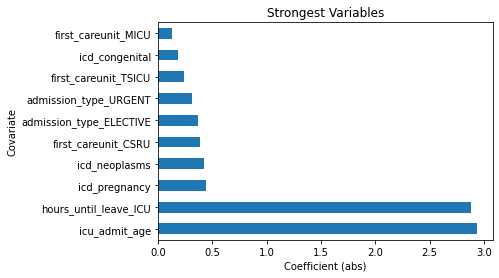

In [233]:
back_vars.sort_values(ascending = False)[:10].plot.barh()
plt.ylabel('Covariate')
plt.xlabel('Coefficient (abs)')
plt.title('Strongest Variables')

In [234]:
cox_model = CoxPHFitter()
cox_model.fit(icd_train_input[model_vars], "time", event_col = "anytime_expire_flag")

<lifelines.CoxPHFitter: fitted with 20888 total observations, 14239 right-censored observations>

In [235]:
cox_model.score(icd_val_input[model_vars], scoring_method='concordance_index')

0.7498404370456413

In [236]:
aft_icd_train = icd_train_input[icd_train_input.time > 0]
aft_icd_test = icd_test_input[icd_test_input.time > 0]
n_aft = WeibullAFTFitter()
n_aft.fit(aft_icd_train[model_vars], 'time', event_col='anytime_expire_flag')

n_aft.score(aft_icd_test[model_vars], scoring_method='concordance_index')

0.7248774033938925

In [237]:
def transform_to_scikit(df):
    s_input = df.drop(labels=['time', 'anytime_expire_flag'], axis=1)
    s_target = df[['anytime_expire_flag', 'time']]
    s_target.anytime_expire_flag = s_target.anytime_expire_flag.apply(lambda x: False if x==0 else True)
    s_target = s_target.to_records(index=False)
    return s_input, s_target

In [238]:
s_icd_train_input, s_icd_train_target = transform_to_scikit(icd_train_input)
s_icd_test_input, s_icd_test_target = transform_to_scikit(icd_test_input)
s_icd_val_input, s_icd_val_target = transform_to_scikit(icd_val_input)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
def model_concordance_index(y, y_pred):
    df = pd.DataFrame(y)
    event = df.iloc[:,0]
    time = df.iloc[:,1]
    return concordance_index_censored(event, time, y_pred)[0]

In [ ]:
rf_params = {
    'max_depth' : [2, 3, 4, 5, 6, 7, 8],
    'n_estimators' : [50, 100, 250, 500, 1000]
}
rf_model = RandomSurvivalForest()
cv = 3

rf_grid = GridSearchCV(
            estimator=rf_model,
            param_grid=rf_params,
            cv=cv,
            n_jobs=-1,
            scoring=make_scorer(model_concordance_index, greater_is_better=True),
            verbose=2
        )
rf_grid.fit(s_icd_train_input, s_icd_train_target)

In [ ]:
rf_grid.best_score_  

In [ ]:
rf_grid.best_params_

In [239]:
# n_rf_params = rf_grid.best_params_
# n_rf_params['n_jobs'] = -1

n_rf_params = {
    'max_depth' : 8,
    'n_estimators' : 500,
    'n_jobs' : -1
}

In [240]:
n_rf = RandomSurvivalForest(**n_rf_params)
n_rf.fit(s_icd_train_input, s_icd_train_target)

RandomSurvivalForest(max_depth=8, n_estimators=500, n_jobs=-1)

In [55]:
n_rf.score(s_icd_val_input, s_icd_val_target)

0.7886378343015007

In [24]:
rf_model_path = "C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Models\\icd_survival_forest.pkl"
pickle.dump(n_rf, open(rf_model_path, 'wb'))

In [50]:
rf_test_curves = pd.DataFrame(n_rf.predict_survival_function(s_icd_test_input))
# test_curve_path = 'C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\test_curves.feather'
# test_curves = s_icd_test[['subject_id']].reset_index().join(rf_test_curves).drop(labels = ['index'], axis=1)
# test_curves.columns = [str(i) for i in test_curves.columns.to_list()]
# test_curves.to_feather(test_curve_path)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\sksurv\ensemble\forest.py:530: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  FutureWarning)


In [244]:
test_curves = pd.DataFrame(n_rf.predict_survival_function(s_icd_test_input))

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\sksurv\ensemble\forest.py:530: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  FutureWarning)


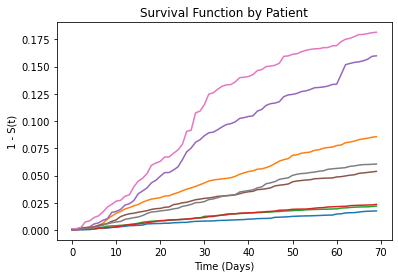

In [247]:
test_plot = test_curves.sample(8).T.iloc[:70,:]
test_plot = test_plot.apply(lambda x: 1-x)
test_plot.plot()
plt.title('Survival Function by Patient')
plt.xlabel('Time (Days)')
plt.ylabel('1 - S(t)')
plt.legend().remove()

In [67]:
rf_cumhaz_curves = pd.DataFrame(n_rf.predict_cumulative_hazard_function(s_icd_test_input))
rf_cumhaz_curves = s_icd_test[['subject_id']].reset_index().join(rf_cumhaz_curves).drop(labels = ['index'], axis=1)
cumhaz_curves_path = 'C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\cumhaz_curves.feather'
rf_cumhaz_curves.columns = [str(i) for i in rf_cumhaz_curves.columns.to_list()]
rf_cumhaz_curves.to_feather(cumhaz_curves_path)
rf_cumhaz_curves

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\sksurv\ensemble\forest.py:462: FutureWarning: predict_cumulative_hazard_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  FutureWarning)


subject_id         0         1         2         3         4         5  \
0          15141  0.000412  0.000433  0.000649  0.000697  0.000814  0.001425   
1          18152  0.000097  0.000117  0.000280  0.000711  0.000951  0.001465   
2          19980  0.000404  0.000475  0.000821  0.001715  0.002240  0.003125   
3          42702  0.000300  0.000411  0.000783  0.000884  0.001219  0.001396   
4          30757  0.000707  0.000728  0.004614  0.006348  0.009623  0.013397   
...          ...       ...       ...       ...       ...       ...       ...   
6536       24236  0.000057  0.000076  0.000152  0.000230  0.000485  0.000733   
6537       22044  0.000114  0.000119  0.000336  0.000677  0.001152  0.001567   
6538       73834  0.000350  0.000730  0.001167  0.001316  0.001520  0.001973   
6539       59225  0.000341  0.000587  0.000936  0.001163  0.001326  0.001608   
6540       24850  0.000090  0.000131  0.000533  0.000599  0.000839  0.001311   

             6         7         8  ...      2258      2259      2260  \
0     0.002373  0.002775  0.003922  ...  0.672047  0.672076  0.672126   
1     0.001753  0.003388  0.004554  ...  1.093962  1.093963  1.093969   
2     0.003813  0.005349  0.006825  ...  0.998322  0.998323  0.998339   
3     0.001904  0.002365  0.002643  ...  0.229595  0.229598  0.229600   
4     0.017016  0.023629  0.032411  ...  1.060223  1.060223  1.060223   
...        ...       ...       ...  ...       ...       ...       ...   
6536  0.000892  0.001124  0.001358  ...  0.376054  0.376353  0.376686   
6537  0.002228  0.004042  0.005727  ...  1.267594  1.267594  1.267598   
6538  0.002283  0.002623  0.003295  ...  0.182528  0.182530  0.182538   
6539  0.002360  0.002965  0.004077  ...  0.234103  0.234104  0.234111   
6540  0.002756  0.003032  0.003698  ...  0.763988  0.764026  0.764059   

          2261      2262      2263      2264      2265      2266      2267  
0     0.672130  0.673167  0.673167  0.674295  0.674300  0.674847  0.674894  
1     1.094260  1.094283  1.094283  1.094335  1.094491  1.095194  1.095213  
2     0.998347  0.999658  0.999659  0.999840  0.999848  1.000540  1.000624  
3     0.229600  0.229665  0.229719  0.229730  0.229730  0.230394  0.230432  
4     1.060223  1.060223  1.060223  1.060233  1.060233  1.060233  1.060233  
...        ...       ...       ...       ...       ...       ...       ...  
6536  0.376834  0.376933  0.376947  0.376947  0.376977  0.378616  0.378617  
6537  1.267720  1.267834  1.267838  1.267872  1.267931  1.267951  1.267960  
6538  0.182543  0.182543  0.182603  0.182610  0.182611  0.182611  0.182611  
6539  0.234117  0.234117  0.234223  0.234245  0.234310  0.234310  0.234314  
6540  0.764170  0.765334  0.765336  0.765490  0.765706  0.766021  0.766021  

[6541 rows x 2269 columns]

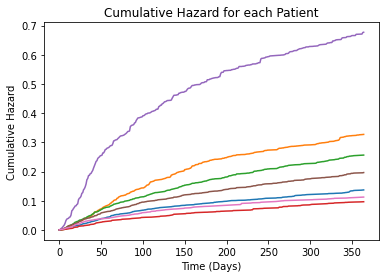

In [59]:
rf_cumhaz_curves.T.iloc[0:365, 0:7].plot()
plt.title('Cumulative Hazard for each Patient')
plt.xlabel('Time (Days)')
plt.ylabel('Cumulative Hazard')
plt.legend().remove()

In [64]:
subject_diagnoses = s_icd_test
# s_icd_test.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'icustay_id',
       'anytime_expire_flag', 'hospital_expire_flag', 'icu_expire_flag',
       'time_of_death', 'time_until_death', 'hours_until_death',
       'days_until_death', 'admittime', 'dischtime', 'intime', 'outtime',
       'time_until_hospital_exit', 'days_until_hospital_exit',
       'admission_time_until_icu', 'hours_until_icu_admission',
       'time_until_leave_ICU', 'hours_until_leave_ICU', 'icu_admit_age',
       'female', 'dbsource', 'first_careunit', 'admission_type',
       'marital_status', 'insurance', 'icd_blood', 'icd_circulatory',
       'icd_congenital', 'icd_digestive', 'icd_endocrine', 'icd_genitourinary',
       'icd_infectious', 'icd_injury', 'icd_mental', 'icd_misc',
       'icd_muscular', 'icd_neoplasms', 'icd_nervous', 'icd_pregnancy',
       'icd_prenatal', 'icd_respiratory', 'icd_skin', 'diagnosis', 'cardio',
       'infection', 'brain', 'mental', 'gastro', 'trauma', 'respiratory',
       'organ', 'blood', 

In [ ]:
boost_param_grid = {
    'max_depth' : [1, 2, 3, 4, 5],
    'n_estimators' : [50, 100, 250, 500],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3]   
}

g_boost = GradientBoostingSurvivalAnalysis()
cv=2

grid = GridSearchCV(
            estimator=g_boost,
            param_grid=boost_param_grid,
            cv=cv,
            n_jobs=-1,
            scoring=make_scorer(model_concordance_index, greater_is_better=True),
            verbose=2
        )
grid.fit(s_icd_train_input, s_icd_train_target)

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
icd_boost_params = {'max_depth': 4, 'n_estimators': 250}
n_boost = GradientBoostingSurvivalAnalysis(**icd_boost_params)
n_boost.fit(s_icd_train_input, s_icd_train_target)

In [ ]:
n_boost.score(s_icd_val_input, s_icd_val_target)

### ICU Static Model

### Baseline Hazard

After grid search, Gradient Boosting was found to perform the best on the test and validation set. Unfortunately, this method can predict a risk value to a patient, which can be used to 

## Time Varying Regression



In [13]:
bp_weight_path = "C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\sa02_nbp_wt.csv"
hr_resp_path = "C:\\Users\\mgaut\\Documents\\Info_Vis_Project\\Data\\hr_spo02_resp.csv"

bp_weight = pd.read_csv(bp_weight_path, parse_dates = ['charttime'],)
hr_resp = pd.read_csv(hr_resp_path, parse_dates = ['charttime'],)

In [87]:
hr_flag_data

subject_id           charttime  HR Alarm [High]  HR Alarm [Low]  \
0              27661 2129-10-10 11:30:00                0               1   
1              27661 2129-09-21 08:00:00                0               1   
2              27661 2129-07-26 08:00:00                0               1   
3              27661 2129-06-14 08:00:00                0               0   
4              27661 2129-10-02 02:00:00                1               0   
...              ...                 ...              ...             ...   
15100879       22780 2128-04-01 04:00:00                0               0   
15100880       22780 2128-04-01 14:00:00                0               0   
15100881       22780 2128-03-26 09:00:00                0               0   
15100882       22780 2128-03-31 10:00:00                0               0   
15100883       22780 2128-03-29 21:00:00                0               0   

          Resp Alarm [High]  Resp Alarm [Low]  SpO2 Alarm [High]  \
0                         0                 0                  0   
1                         0                 0                  0   
2                         0                 0                  0   
3                         0                 0                  0   
4                         0                 0                  0   
...                     ...               ...                ...   
15100879                  0                 0                  1   
15100880                  0                 0                  0   
15100881                  0                 1                  0   
15100882                  0                 0                  1   
15100883                  1                 0                  0   

          SpO2 Alarm [Low]  
0                        0  
1                        0  
2                        0  
3                        1  
4                        0  
...                    ...  
15100879                 0  
15100880                 1  
15100881                 0  
15100882                 0  
15100883                 0  

[15100884 rows x 8 columns]

In [15]:
alarms = {'NBP Alarm [Low]', 'NBP Alarm [High]'}
bp_weight = bp_weight[bp_weight.label.isin(alarms)]

In [16]:
bp_flag_data = pd.concat([bp_weight[['subject_id', 'charttime']], pd.get_dummies(bp_weight.label)], axis=1)
hr_flag_data = pd.concat([hr_resp[['subject_id', 'charttime']], pd.get_dummies(hr_resp.label)], axis=1)
# flag_data = hr_flag_data.set_index('subject_id').merge(bp_flag_data.set_index('subject_id'),
#                                                        right_on = 'subject_id', left_index=True)
train_admit_times = icd_train[['subject_id', 'admittime']]
test_admit_times = icd_test[['subject_id', 'admittime']]

In [17]:
def generate_time_data(flag_data, split_data, num_patients=None, rebalance_factor=None):
    
    admit_times = split_data[['subject_id', 'intime', 'outtime']]
    if num_patients:
        admit_times = admit_times.sample(num_patients)
        admit_subjects = admit_times[['subject_id']]
    data_time = admit_times.join(flag_data.set_index('subject_id'), on='subject_id')
    print('Joined flags to admissions...')
    
    data_time = data_time[~data_time.outtime.isnull()]
#     data_time['intime'] = data_time.intime.astype('datetime64')
#     data_time['outtime'] = data_time.outtime.astype('datetime64')
#     data_time['charttime'] = data_time.outtime.astype('datetime64')
    data_time['charttime'] = data_time.charttime.fillna(data_time['outtime'])
    data_time = data_time.fillna(0)
    data_time['duration'] = ((data_time['charttime'] - data_time['intime'])/np.timedelta64(1,'h')).apply(int)
    data_time = data_time.drop(labels = ['intime', 'outtime', 'charttime'], axis=1)
    print('Generated durations from chart events...')
    
    ident_vars = {'subject_id', 'icu_expire_flag', 'hours_until_leave_ICU', 'hours_until_death'}
    patient_duration = split_data[ident_vars]
    if num_patients:
        patient_duration = admit_subjects.join(patient_duration.set_index('subject_id'), on='subject_id')
    patient_duration['duration'] = patient_duration.apply(
        lambda row: int(min(row.hours_until_leave_ICU, row.hours_until_death)), axis=1)
    patient_duration['event'] = patient_duration['icu_expire_flag'].apply(lambda x: True if x == 1 else False)
    patient_duration = patient_duration.drop(labels = ['icu_expire_flag', 'hours_until_leave_ICU', 'hours_until_death'], axis=1)
    patient_duration = to_long_format(patient_duration, duration_col='duration')
    
    print('Converted data to long format...')
    time_data_df = add_covariate_to_timeline(patient_duration, data_time, duration_col="duration", id_col="subject_id", event_col="event")
    time_data_df = time_data_df.fillna(0)
    time_data_df['start'] = time_data_df['start'] + 1
    time_data_df['stop'] = time_data_df['stop'] + 1
    print('Complete')
    
    return time_data_df
    
    

In [34]:
hr_time_data = generate_time_data(hr_flag_data, icd_train,)

Joined flags to admissions...
Generated durations from chart events...


C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Converted data to long format...
Complete


In [35]:
hr_time_data = hr_time_data.loc[~((hr_time_data['start'] == hr_time_data['stop']) & (hr_time_data['start'] == 0))]
hr_time_data['stop'] = np.where(((hr_time_data['start'] == hr_time_data['stop']) & (hr_time_data['event'] == True)),
                                hr_time_data['stop']+1, hr_time_data['stop'])

# hr_time_data.loc[((hr_time_data['start'] == hr_time_data['stop']) & (hr_time_data['event'] == True))]
# hr_time_data = hr_time_data[~hr_time_data.subject_id.isin([532, 2601, 10067, 21059, 21692])]

In [36]:
cox_time = CoxTimeVaryingFitter()
cox_time.fit(hr_time_data, event_col='event', id_col='subject_id', show_progress=True)

Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -15784.57046, newton_decrement = 0.00000, seconds_since_start = 112.2Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 6219963 periods, 23392 subjects, 1808 events>

In [37]:
cox_time.summary

coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                          
HR Alarm [High]    0.017450   1.017603  0.098550       -0.175703   
HR Alarm [Low]    -0.088010   0.915752  0.103274       -0.290424   
Resp Alarm [High]  0.011534   1.011601  0.099783       -0.184037   
Resp Alarm [Low]  -0.044335   0.956633  0.102371       -0.244978   
SpO2 Alarm [High] -0.000891   0.999110  0.100209       -0.197297   
SpO2 Alarm [Low]  -0.135493   0.873285  0.105696       -0.342653   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                     
HR Alarm [High]          0.210604             0.838867             1.234423   
HR Alarm [Low]           0.114404             0.747947             1.121205   
Resp Alarm [High]        0.207105             0.831905             1.230112   
Resp Alarm [Low]         0.156308             0.782722             1.169186   
SpO2 Alarm [High]        0.195516             0.820947             1.215938   
SpO2 Alarm [Low]         0.071667             0.709885             1.074297   

                          z         p  -log2(p)  
covariate                                        
HR Alarm [High]    0.177071  0.859453  0.218510  
HR Alarm [Low]    -0.852195  0.394106  1.343344  
Resp Alarm [High]  0.115591  0.907977  0.139273  
Resp Alarm [Low]  -0.433085  0.664953  0.588676  
SpO2 Alarm [High] -0.008888  0.992909  0.010267  
SpO2 Alarm [Low]  -1.281915  0.199873  2.322848

In [31]:
hr_time_data.corr()

start  HR Alarm [High]  HR Alarm [Low]  \
start              1.000000e+00     6.237709e-07        0.000183   
HR Alarm [High]    6.237709e-07     1.000000e+00       -0.200636   
HR Alarm [Low]     1.827244e-04    -2.006357e-01        1.000000   
Resp Alarm [High]  2.112475e-03    -1.988007e-01       -0.198959   
Resp Alarm [Low]   2.310249e-03    -1.989124e-01       -0.199071   
SpO2 Alarm [High]  6.653116e-04    -1.999637e-01       -0.200123   
SpO2 Alarm [Low]   3.381088e-04    -2.004672e-01       -0.200627   
stop               9.992817e-01    -4.786871e-04       -0.000301   
subject_id        -7.487728e-02    -4.526314e-03       -0.004669   
event             -7.892808e-03    -4.428640e-03       -0.005211   

                   Resp Alarm [High]  Resp Alarm [Low]  SpO2 Alarm [High]  \
start                       0.002112          0.002310           0.000665   
HR Alarm [High]            -0.198801         -0.198912          -0.199964   
HR Alarm [Low]             -0.198959         -0.199071          -0.200123   
Resp Alarm [High]           1.000000         -0.197250          -0.198293   
Resp Alarm [Low]           -0.197250          1.000000          -0.198404   
SpO2 Alarm [High]          -0.198293         -0.198404           1.000000   
SpO2 Alarm [Low]           -0.198792         -0.198904          -0.199955   
stop                        0.001633          0.001834           0.000181   
subject_id                 -0.001542         -0.001454          -0.004210   
event                      -0.004526         -0.004891          -0.005180   

                   SpO2 Alarm [Low]      stop  subject_id     event  
start                      0.000338  0.999282   -0.074877 -0.007893  
HR Alarm [High]           -0.200467 -0.000479   -0.004526 -0.004429  
HR Alarm [Low]            -0.200627 -0.000301   -0.004669 -0.005211  
Resp Alarm [High]         -0.198792  0.001633   -0.001542 -0.004526  
Resp Alarm [Low]          -0.198904  0.001834   -0.001454 -0.004891  
SpO2 Alarm [High]         -0.199955  0.000181   -0.004210 -0.005180  
SpO2 Alarm [Low]           1.000000 -0.000146   -0.004388 -0.005561  
stop                      -0.000146  1.000000   -0.071882 -0.000904  
subject_id                -0.004388 -0.071882    1.000000  0.031496  
event                     -0.005561 -0.000904    0.031496  1.000000

In [241]:
icd_train_time = train_admit_times.join(hr_flag_data.set_index('subject_id'), on='subject_id')
icd_train_time['charttime'] = icd_train_time.charttime.fillna(icd_train_time['admittime'])
icd_train_time = icd_train_time.dropna()
icd_train_time['time_step'] = ((icd_train_time['charttime'] - icd_train_time['admittime'])/np.timedelta64(1,'h')).apply(int)
icd_train_time = icd_train_time.drop(labels = ['admittime', 'charttime'], axis=1)

In [242]:
icd_test_time = test_admit_times.join(bp_flag_data.set_index('subject_id'), on='subject_id')
icd_test_time['charttime'] = icd_test_time.charttime.fillna(icd_test_time['admittime'])
icd_test_time = icd_test_time.dropna()
icd_test_time['time_step'] = ((icd_test_time['charttime'] - icd_test_time['admittime'])/np.timedelta64(1,'h')).apply(int)
icd_test_time = icd_test_time.drop(labels = ['admittime', 'charttime'], axis=1)

In [204]:
# train_admit_times.join(bp_flag_data.set_index('subject_id'), on='subject_id')
icd_train.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'icustay_id',
       'anytime_expire_flag', 'hospital_expire_flag', 'icu_expire_flag',
       'time_of_death', 'time_until_death', 'hours_until_death',
       'days_until_death', 'admittime', 'dischtime', 'intime', 'outtime',
       'time_until_hospital_exit', 'days_until_hospital_exit',
       'admission_time_until_icu', 'hours_until_icu_admission',
       'time_until_leave_ICU', 'hours_until_leave_ICU', 'icu_admit_age',
       'female', 'dbsource', 'first_careunit', 'admission_type',
       'marital_status', 'insurance', 'icd_blood', 'icd_circulatory',
       'icd_congenital', 'icd_digestive', 'icd_endocrine', 'icd_genitourinary',
       'icd_infectious', 'icd_injury', 'icd_mental', 'icd_misc',
       'icd_muscular', 'icd_neoplasms', 'icd_nervous', 'icd_pregnancy',
       'icd_prenatal', 'icd_respiratory', 'icd_skin', 'diagnosis', 'cardio',
       'infection', 'brain', 'mental', 'gastro', 'trauma', 'respiratory',
       'organ', 'blood', 

In [243]:
remove_vars = {'hours_until_leave_ICU'}
ident_vars = ['subject_id', 'icu_expire_flag', 'hours_until_leave_ICU', 'hours_until_death']
time_vars = [var for var in model_vars if not var in remove_vars]

In [244]:
time_train_input, time_test_input, time_val_input = generate_icd_data(icd_train, icd_test, icd_val)

In [330]:
time_train = icd_train[ident_vars].join(icd_train_time.set_index('subject_id'), on = 'subject_id')
time_train['hours_until_death'] = time_train.apply(
    lambda row: int(min(row.hours_until_leave_ICU, row.hours_until_death)), axis=1)

In [ ]:
time

In [ ]:
time_test = icd_test[ident_vars].join(icd_test_time.set_index('subject_id'), on = 'subject_id')
time_test['hours_until_death'] = time_test.apply(
    lambda row: int(min(row.hours_until_leave_ICU, row.hours_until_death)), axis=1)

In [77]:
# time_train['event'] = time_train.apply(
#     lambda row: True if (row.icu_expire_flag == 1) & (row.time_step == row.hours_until_death) else False, axis=1)

# time_test['event'] = time_test.apply(
#     lambda row: True if (row.icu_expire_flag == 1) & (row.time_step == row.hours_until_death) else False, axis=1)

In [ ]:
time_train_vars = time_train_input[time_vars].drop(labels = ['time', 'anytime_expire_flag'], axis=1)
time_test_vars = time_test_input[time_vars].drop(labels = ['time', 'anytime_expire_flag'], axis=1)

In [ ]:
time_train_df = time_train.drop(['hours_until_leave_ICU', 'hours_until_death', 'icu_expire_flag'], axis=1)
time_train_df = time_train_df.rename(columns={'subject_id' : 'id', 'time_step':'duration'})

time_test_df = time_test.drop(['hours_until_leave_ICU', 'hours_until_death', 'icu_expire_flag'], axis=1)
time_test_df = time_test_df.rename(columns={'subject_id' : 'id', 'time_step':'duration'})

In [ ]:
time_train_df.dropna().shape

In [112]:
time_ids = ['id', 'duration']
cv1 = time_train_df[['ABP Alarm [Low]']+time_ids]
cv2 = time_train_df[['ABP Alarm [High]']+time_ids]
cv3 = time_train_df[['NBP Alarm [High]']+time_ids]
# cv3 = cv3[cv3['NBP Alarm [High]']==1]
cv4 = time_train_df[['NBP Alarm [Low]']+time_ids]
# cv4 = cv4[cv4['NBP Alarm [Low]']==1]

tv3 = time_test_df[['NBP Alarm [High]']+time_ids]
tv3 = tv3[tv3['NBP Alarm [High]']==1]
tv4 = time_test_df[['NBP Alarm [Low]']+time_ids]
tv4 = tv4[tv4['NBP Alarm [Low]']==1]

In [ ]:
patient_duration = icd_train[ident_vars]
patient_duration['duration'] = patient_duration.apply(
    lambda row: int(min(row.hours_until_leave_ICU, row.hours_until_death)), axis=1)
patient_duration['event'] = patient_duration['icu_expire_flag'].apply(lambda x: True if x == 1 else False)
patient_duration = patient_duration.drop(labels = ['icu_expire_flag', 'hours_until_leave_ICU', 'hours_until_death'], axis=1)
patient_duration = to_long_format(patient_duration, duration_col='duration').rename(columns = {'subject_id':'id'})


In [ ]:
test_duration = icd_test[ident_vars]
test_duration['duration'] = test_duration.apply(
    lambda row: int(min(row.hours_until_leave_ICU, row.hours_until_death)), axis=1)
test_duration['event'] = test_duration['icu_expire_flag'].apply(lambda x: True if x == 1 else False)
test_duration = test_duration.drop(labels = ['icu_expire_flag', 'hours_until_leave_ICU', 'hours_until_death'], axis=1)
test_duration = to_long_format(test_duration, duration_col='duration').rename(columns = {'subject_id':'id'})

In [ ]:
# add_covariate_to_timeline(long_form_df, cv, id_col, duration_col, event_col, start_col='start', stop_col='stop',
# add_enum=False, overwrite=True, cumulative_sum=False, cumulative_sum_prefix='cumsum_', delay=0)

# patient_time = add_covariate_to_timeline(patient_duration, cv1, 
#                                          id_col='id', duration_col='duration', event_col='event')

n_train_df = add_covariate_to_timeline(patient_duration, time_train_df.drop(labels=['event', 'ABP Alarm [High]',
                                                                                    'ABP Alarm [Low]'], axis=1),
                                       duration_col="duration", id_col="id", event_col="event")

In [115]:
train_df = patient_duration.pipe(add_covariate_to_timeline, cv3, duration_col="duration", id_col="id", event_col="event")\
                           .pipe(add_covariate_to_timeline, cv4, duration_col="duration", id_col="id", event_col="event")
#                      .pipe(add_covariate_to_timeline, cv1, duration_col="duration", id_col="id", event_col="event")\
#                      .pipe(add_covariate_to_timeline, cv2, duration_col="duration", id_col="id", event_col="event")\

test_df = test_duration.pipe(add_covariate_to_timeline, tv3, duration_col="duration", id_col="id", event_col="event")\
                       .pipe(add_covariate_to_timeline, tv4, duration_col="duration", id_col="id", event_col="event")

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\lifelines\utils\__init__.py:1453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv[duration_col] += delay
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\lifelines\utils\__init__.py:1453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv[duration_col] += delay


In [169]:
print(train_df.shape)
print(n_train_df.shape)

(4599913, 7)
(1450757, 6)


In [198]:
train_df.head(50)

start  NBP Alarm [High]  NBP Alarm [Low]   stop  id  event    hazard
0       0               0.0              0.0  145.0   3  False  5.683215
1       0               0.0              0.0   40.0   4  False  5.683215
2       0               0.0              0.0  117.0   9   True  5.683215
3       0               0.0              1.0    0.0  11  False  1.121876
4       0               1.0              0.0    0.0  11  False  0.884118
5       0               0.0              1.0    1.0  11  False  1.121876
6       1               1.0              0.0    1.0  11  False  0.884118
7       1               0.0              1.0    2.0  11  False  1.121876
8       2               1.0              0.0    2.0  11  False  0.884118
9       2               0.0              1.0    3.0  11  False  1.121876
10      3               1.0              0.0    3.0  11  False  0.884118
11      3               0.0              1.0    4.0  11  False  1.121876
12      4               1.0              0.0    4.0  11  False  0.884118
13      4               0.0              1.0    5.0  11  False  1.121876
14      5               1.0              0.0    5.0  11  False  0.884118
15      5               0.0              1.0    6.0  11  False  1.121876
16      6               1.0              0.0    6.0  11  False  0.884118
17      6               0.0              1.0    7.0  11  False  1.121876
18      7               1.0              0.0    7.0  11  False  0.884118
19      7               0.0              1.0    8.0  11  False  1.121876
20      8               1.0              0.0    8.0  11  False  0.884118
21      8               0.0              1.0    9.0  11  False  1.121876
22      9               1.0              0.0   10.0  11  False  0.884118
23     10               0.0              1.0   10.0  11  False  1.121876
24     10               1.0              0.0   11.0  11  False  0.884118
25     11               0.0              1.0   12.0  11  False  1.121876
26     12               1.0              0.0   13.0  11  False  0.884118
27     13               0.0              1.0   13.0  11  False  1.121876
28     13               1.0              0.0   14.0  11  False  0.884118
29     14               0.0              1.0   14.0  11  False  1.121876
30     14               1.0              0.0   15.0  11  False  0.884118
31     15               0.0              1.0   15.0  11  False  1.121876
32     15               1.0              0.0   16.0  11  False  0.884118
33     16               0.0              1.0   17.0  11  False  1.121876
34     17               1.0              0.0   17.0  11  False  0.884118
35     17               0.0              1.0   18.0  11  False  1.121876
36     18               1.0              0.0   18.0  11  False  0.884118
37     18               0.0              1.0   19.0  11  False  1.121876
38     19               1.0              0.0   19.0  11  False  0.884118
39     19               0.0              1.0   20.0  11  False  1.121876
40     20               1.0              0.0   21.0  11  False  0.884118
41     21               0.0              1.0   21.0  11  False  1.121876
42     21               1.0              0.0   22.0  11  False  0.884118
43     22               0.0              1.0   23.0  11  False  1.121876
44     23               1.0              0.0   23.0  11  False  0.884118
45     23               0.0              1.0   24.0  11  False  1.121876
46     24               1.0              0.0   24.0  11  False  0.884118
47     24               0.0              1.0   25.0  11  False  1.121876
48     25               1.0              0.0   25.0  11  False  0.884118
49     25               0.0              1.0   26.0  11  False  1.121876

In [ ]:
train_df = train_df.fillna(0)
train_df['start'] = train_df['start'] + 1
train_df['stop'] = train_df['stop'] + 1
cox_time = CoxTimeVaryingFitter()
cox_time.fit(train_input_df, event_col='event', id_col='id')

In [221]:
cox_time.summary

coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                          
HR Alarm [High]    0.017450   1.017603  0.098550       -0.175703   
HR Alarm [Low]    -0.088010   0.915752  0.103274       -0.290424   
Resp Alarm [High]  0.011534   1.011601  0.099783       -0.184037   
Resp Alarm [Low]  -0.044335   0.956633  0.102371       -0.244978   
SpO2 Alarm [High] -0.000891   0.999110  0.100209       -0.197297   
SpO2 Alarm [Low]  -0.135493   0.873285  0.105696       -0.342653   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                     
HR Alarm [High]          0.210604             0.838867             1.234423   
HR Alarm [Low]           0.114404             0.747947             1.121205   
Resp Alarm [High]        0.207105             0.831905             1.230112   
Resp Alarm [Low]         0.156308             0.782722             1.169186   
SpO2 Alarm [High]        0.195516             0.820947             1.215938   
SpO2 Alarm [Low]         0.071667             0.709885             1.074297   

                          z         p  -log2(p)  
covariate                                        
HR Alarm [High]    0.177071  0.859453  0.218510  
HR Alarm [Low]    -0.852195  0.394106  1.343344  
Resp Alarm [High]  0.115591  0.907977  0.139273  
Resp Alarm [Low]  -0.433085  0.664953  0.588676  
SpO2 Alarm [High] -0.008888  0.992909  0.010267  
SpO2 Alarm [Low]  -1.281915  0.199873  2.322848

Text(0.5, 1.0, 'Feature Importance')

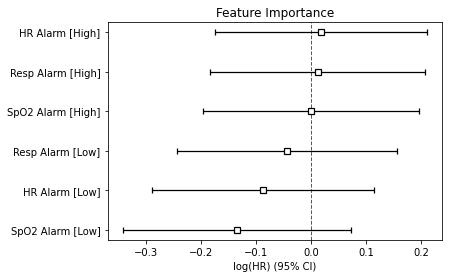

In [223]:
cox_time.plot()
plt.title('Feature Importance')

In [ ]:
time_base_cumhaz = cox_time.baseline_cumulative_hazard_

In [133]:
cox_time.predict_partial_hazard(train_df)

0          5.683215
1          5.683215
2          5.683215
3          1.121876
4          0.884118
             ...   
4599908    5.683215
4599909    5.683215
4599910    5.683215
4599911    5.683215
4599912    5.683215
Length: 4599913, dtype: float64

In [151]:
train_df['hazard'] = cox_time.predict_partial_hazard(train_df)
train_df.head(50)

start  NBP Alarm [High]  NBP Alarm [Low]   stop  id  event    hazard
0       0               0.0              0.0  145.0   3  False  5.683215
1       0               0.0              0.0   40.0   4  False  5.683215
2       0               0.0              0.0  117.0   9   True  5.683215
3       0               0.0              1.0    0.0  11  False  1.121876
4       0               1.0              0.0    0.0  11  False  0.884118
5       0               0.0              1.0    1.0  11  False  1.121876
6       1               1.0              0.0    1.0  11  False  0.884118
7       1               0.0              1.0    2.0  11  False  1.121876
8       2               1.0              0.0    2.0  11  False  0.884118
9       2               0.0              1.0    3.0  11  False  1.121876
10      3               1.0              0.0    3.0  11  False  0.884118
11      3               0.0              1.0    4.0  11  False  1.121876
12      4               1.0              0.0    4.0  11  False  0.884118
13      4               0.0              1.0    5.0  11  False  1.121876
14      5               1.0              0.0    5.0  11  False  0.884118
15      5               0.0              1.0    6.0  11  False  1.121876
16      6               1.0              0.0    6.0  11  False  0.884118
17      6               0.0              1.0    7.0  11  False  1.121876
18      7               1.0              0.0    7.0  11  False  0.884118
19      7               0.0              1.0    8.0  11  False  1.121876
20      8               1.0              0.0    8.0  11  False  0.884118
21      8               0.0              1.0    9.0  11  False  1.121876
22      9               1.0              0.0   10.0  11  False  0.884118
23     10               0.0              1.0   10.0  11  False  1.121876
24     10               1.0              0.0   11.0  11  False  0.884118
25     11               0.0              1.0   12.0  11  False  1.121876
26     12               1.0              0.0   13.0  11  False  0.884118
27     13               0.0              1.0   13.0  11  False  1.121876
28     13               1.0              0.0   14.0  11  False  0.884118
29     14               0.0              1.0   14.0  11  False  1.121876
30     14               1.0              0.0   15.0  11  False  0.884118
31     15               0.0              1.0   15.0  11  False  1.121876
32     15               1.0              0.0   16.0  11  False  0.884118
33     16               0.0              1.0   17.0  11  False  1.121876
34     17               1.0              0.0   17.0  11  False  0.884118
35     17               0.0              1.0   18.0  11  False  1.121876
36     18               1.0              0.0   18.0  11  False  0.884118
37     18               0.0              1.0   19.0  11  False  1.121876
38     19               1.0              0.0   19.0  11  False  0.884118
39     19               0.0              1.0   20.0  11  False  1.121876
40     20               1.0              0.0   21.0  11  False  0.884118
41     21               0.0              1.0   21.0  11  False  1.121876
42     21               1.0              0.0   22.0  11  False  0.884118
43     22               0.0              1.0   23.0  11  False  1.121876
44     23               1.0              0.0   23.0  11  False  0.884118
45     23               0.0              1.0   24.0  11  False  1.121876
46     24               1.0              0.0   24.0  11  False  0.884118
47     24               0.0              1.0   25.0  11  False  1.121876
48     25               1.0              0.0   25.0  11  False  0.884118
49     25               0.0              1.0   26.0  11  False  1.121876